In [13]:
import scanpy as sc
import phate
import scprep
import gspa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# data and metadata from https://www.nature.com/articles/s41587-019-0336-3
data = pd.read_pickle('data/eb_data.pkl.gz')
metadata = pd.read_pickle('data/eb_metadata.pkl.gz')
adata = sc.AnnData(data)
adata.obs = metadata

In [10]:
phate_op = phate.PHATE(random_state=42, verbose=False)
data_phate = phate_op.fit_transform(adata.to_df())
data_phate[:, 0] = data_phate[:, 0] * -1 # ensures timepoints increase from left to right

<Axes: title={'center': 'Embedding all genes'}>

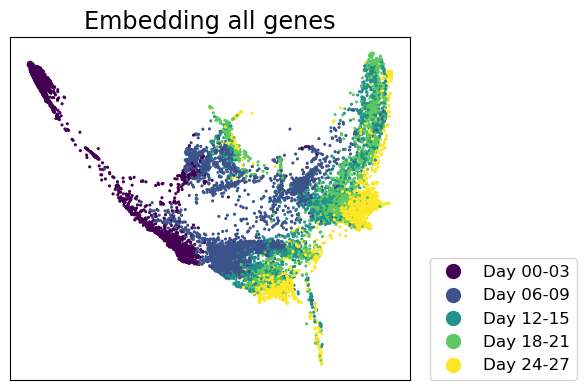

In [8]:
scprep.plot.scatter2d(data_phate, c=adata.obs['sample_labels'], legend_loc=(1.05, 0), figsize=(6,4), ticks=None, dpi=300,
                      title='Embedding all genes', filename='figures/eb_embedding.png', cmap='viridis')

In [ ]:
gspa_op = gspa.GSPA(graph=phate_op.graph, random_state=1234)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()
gene_signals = adata.to_df().T
gene_ae, gene_pc = gspa_op.get_gene_embeddings(gene_signals)
gene_localization = gspa_op.calculate_localization()

In [ ]:
np.savez('../results/eb_gene_embedding.npz', signal_embedding=gene_ae,
         localization_score=gene_localization, genes=adata.var_names)

## Gene embedding analysis

In [105]:
results = np.load('../results/eb_gene_embedding.npz', allow_pickle=True)
genes = np.array([x.split(' (')[0] for x in results['genes']])

In [107]:
## mitochondrial genes show very different trend; remove for this analysis

gene_phate_op = phate.PHATE(random_state=42, t=40, use_pygsp=True)
gene_phate = gene_phate_op.fit_transform(results['signal_embedding'][~pd.Series(genes).isin(['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND5'])])
genes = genes[~pd.Series(genes).isin(['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND5'])]

Calculating PHATE...
  Running PHATE on 17835 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 60.05 seconds.
    Calculating affinities...
    Calculated affinities in 30.79 seconds.
  Calculated graph and diffusion operator in 91.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.33 seconds.
  Calculated landmark operator in 10.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.72 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.73 seconds.
Calculated PHATE in 108.59 seconds.


In [69]:
evs = gene_phate_op.graph.U
evs_sub = evs[:, :50]
evs_sub = pd.DataFrame(MinMaxScaler().fit_transform(evs_sub), index=genes)

2024-05-23 16:30:33,530:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.
2024-05-23 16:30:33,531:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (17845 x 17845) may take some time.


In [116]:
evs_sub.index= np.array([x.split(' (')[0] for x in results['genes']])
evs_sub_no_mt = evs_sub.loc[~evs_sub.index.isin(['MT-ATP6', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1',
       'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND5'])]

In [135]:
hemangioblast_lineage = [['NANOG', 'POU5F1'], ['EOMES', 'MIXL1', 'CER1', 'SATB1', 'T'], ['T'],
                     ['TAL1', 'CD34', 'PECAM1']]

In [198]:
df = pd.DataFrame((1-evs_sub.loc[[y for x in hemangioblast_lineage for y in x]][4]).sort_values())

In [199]:
df

,4
NANOG,0.059869
POU5F1,0.060040
SATB1,0.060227
T,0.063060
T,0.063060
EOMES,0.063427
MIXL1,0.064142
CER1,0.064248
PECAM1,0.551592
TAL1,0.580715


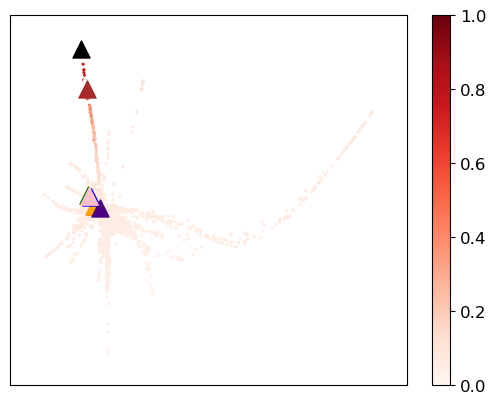

In [194]:
fig, ax = plt.subplots()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'pink', 'white', 'black', 'brown']
scprep.plot.scatter2d(gene_phate, c=1-evs_sub_no_mt[4], ax=ax, cmap='Reds')
for i,gene in enumerate([y for x in hemangioblast_lineage for y in x]):
    scprep.plot.scatter2d(gene_phate, mask=pd.Series(genes).isin([gene]), marker='^',
                          ax=ax, s=150, ticks=None, label=gene, c=colors[i])

fig.savefig('figures/eb_selected_genes.png', dpi=300)